In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# <div class=consignes>Deep Learning et traitement du signal TP 1 </div>
<div class=consignes> L'objectif de ce TP est de prendre en main les outils de modélisation et d'analyse du signal présentés dans le premier cours et d'introduire la problématique de <it>détection</it> dont on parlera dans le cours numéro 3 </div>
<div class=consignes>Deadline : 16 octobre 2024, 13h59, par mail à deepetsignal.mva@gmail.com <br> Effort estimé : 2 à 3 heures maximum</div>
<div class=consignes>Le rendu de ce TP n'est pas obligatoire. Il permet d'obtenir un bonus de 1 (minimum syndical) à 3 (votre notebook servira de correction l'an prochain) points sur la moyenne des TP </div>

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp1.ipynb </div>

Alexandre Ver Hulst, Antoine Martinez

<div class=consignes>Si vous installez des paquets supplémentaires, merci de les lister dans la cellule suivante avec la syntaxe
    
```
!pip install \< nom_du_paquet \>
```
    
</div>

In [2]:
import numpy as np 
import matplotlib.pylab as plt 
import scipy
import IPython.display as ipd

## <div class=consignes>Partie 1: Audio </div>

### <div class=consignes>Visualisation</div>

 <div class=consignes>Enregistrez un fichier wav de quelques secondes de votre voix. 
  <br>
 Importez le avec scipy.io.wavfile.read et écoutez le dans le notebook avec IPython.display.Audio
</div>

In [3]:
# Lire le fichier  coloniedefourmies.wav
# Utiliser la fonction scipy.io.wavfile.read pour lire le fichier

audio = scipy.io.wavfile.read('coloniedefourmies.wav')

# Ecouter l'Audio
ipd.Audio('coloniedefourmies.wav')

<div class=consignes>Visualisez la forme d'onde temporelle de ce signal audio. <br>
Estimez et affichez sa Densité Spectrale de Puissance. <br>
Donnez une interprétation de ce que vous observez. 
    </div>

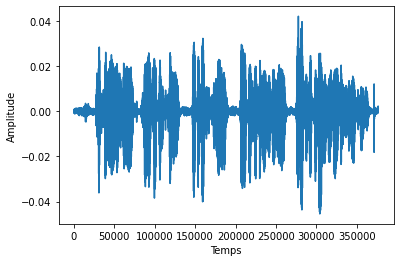

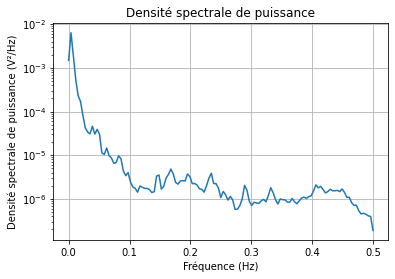

In [4]:
from scipy.signal import welch

# Visualiser la forme d'onde temporelle
plt.plot(audio[1])
plt.xlabel('Temps')
plt.ylabel('Amplitude')

plt.show()

# Calculer la densité spectrale de puissance (Welch)
frequencies, power_spectral_density = welch(audio[1])

# Afficher la DSP
plt.semilogy(frequencies, power_spectral_density)
plt.title('Densité spectrale de puissance')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Densité spectrale de puissance (V²/Hz)')
plt.grid()
plt.show()

INTERPRETATION

<div class=consignes> Calculez et affichez le spectrogramme du signal. <br>
Justifiez du choix des réglages que vous avez faits. <br>
Sélectionnez une portion pertinente du spectrogramme pour estimer visuellement le pitch de votre voix.
    </div>

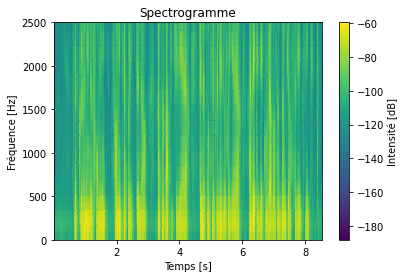

In [24]:
from scipy.signal import spectrogram

# Calculer le spectrogramme
frequencies, times, Sxx = spectrogram(audio[1], fs=audio[0], window='hann', nperseg=256, noverlap=256//2)

# Afficher le spectrogramme
#limiter les fréquences de 0 à 10Hz

plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.title('Spectrogramme')
plt.ylabel('Fréquence [Hz]')
plt.xlabel('Temps [s]')
plt.ylim(bottom = 0,top = 2500)
plt.colorbar(label='Intensité [dB]')
plt.show()

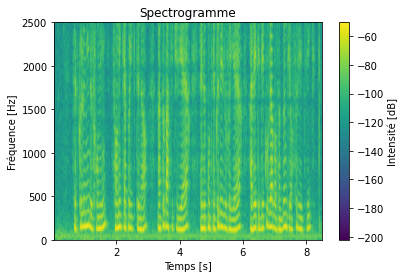

In [23]:
# Calculer le spectrogramme
nperse = 2048
frequencies, times, Sxx = spectrogram(audio[1], fs=audio[0], window='hamming', nperseg=nperse, noverlap=nperse//2)

# Afficher le spectrogramme

plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.title('Spectrogramme')
plt.ylabel('Fréquence [Hz]')
plt.xlabel('Temps [s]')
plt.ylim(bottom = 0,top = 2500)
plt.colorbar(label='Intensité [dB]')
plt.show()

Nous avons choisi un nombre d'échantillon dans la fenêtre de 2048, car d'une part il est préférable que ce soit une puissance de 2 et d'autre part, si nous la prenions plus petite, nous ne voyions pas assez précisément la fréquence des sons, alors que lorsque si l'on augmentait encore la taille de la fenêtre, il nous était plus difficile de percevoir les effets transitoires

### <div class=consignes>Calcul du Pitch</div>

<div class=consignes>Proposez une méthode simple pour estimer automatiquement le Pitch de votre voix (cette méthode ne doit pas faire intervenir d'implémentations externes).

Utilisez cette méthode pour estimer les variations du Pitch le long du signal, estimez le pitch toutes les 20 ms et présentez vos résultats sous forme visuelle. 

Ne pas utiliser de méthode "toute faite" que vous pourriez par exemple trouver dans la bibliothèque librosa.

Commentez vos résultats.
    </div>

Nous avons essayé d'estimer les valeur du pitch de la voix avec l'autocorrélation. En effet après avoir divisé notre signal en fenêtres de 20 ms, nous avons calculé l'autocorrélation de la voix sur chacune et regarder 

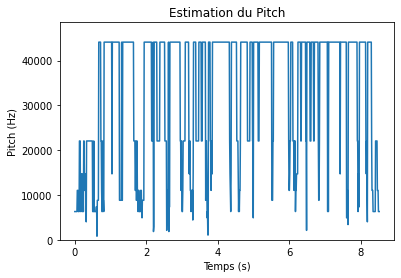

In [28]:
fs = audio[0]
signal = audio[1]

frame_size = int(int(fs * 0.02))  # Nous voulons des fenêtres de 20 ms
hop_size = frame_size//2 # Toujours un recouvrement de la moitié de notre fenêtre

num_frames = (len(signal) - frame_size) // hop_size + 1
pitches = []

for i in range(num_frames):
    frame = signal[i * hop_size:i * hop_size + frame_size]
    autocorr = np.correlate(frame, frame, mode='full')[frame_size-1:]  # Calcul de l'autocorrélation du signal
    
    peak_index = np.argmax(autocorr[1:]) + 1  
    if peak_index > 0:
        pitch = fs / peak_index
        pitches.append(pitch)
    else:
        pitches.append(0)

times = np.arange(num_frames) * hop_size / fs
plt.plot(times, pitches)
plt.title('Estimation du Pitch')
plt.xlabel('Temps (s)')
plt.ylabel('Pitch (Hz)')
plt.ylim(0, max(pitches) * 1.1)  
plt.show()


In [37]:
print(f"Valeur moyenne du Pitch : {int(np.mean(pitches))}" )


Valeur moyenne du Pitch : 33540


On trouve un pitch très élevé aux alentours de 33 KHz, ce qui est trop élevé. Notre méthode ne semble pas fonctionner.

## <div class=consignes>Partie 2: Détection d'impulsion </div>

<div class=consignes> Un signal de durée 1 seconde et échantillonné à 1000 Hz est composé d'un bruit blanc gaussien de puissance inconnue et éventuellement d'une impulsion à une fréquence f0 comprise entre 100 et 200 Hz. 
<br><br>
Une série de 1000 signaux est enregistrée dans le fichier signaux_impulsions.npz. 
Ouvez ce fichier avec numpy (cf code plus bas). Le fichier contient une tableau signaux 10000 x 1000 dont chaque ligne contient un signal de durée 1000. Le fichiez contient aussi un tableau labels de taille 10000 dont la ligne i est à TRUE si le signal i contient une impulsion et à 0 sinon. 

</div>

In [38]:
donnees = np.load('signaux_impulsions.npz')
signaux = donnees['data']
labels = donnees['labels']

## <div class=consignes> Première méthode </div>

<div class=consignes> Proposez une méthode simple  pour décider si un signal contient une impulsion ou non à partir du calcul de l'énergie du signal. Cette méthode fera intervenir un seuil: 
</div>

```python
def contient_impulsion_energie(signal: np.ndarray, seuil: float) -> bool:
```

In [39]:
def contient_impulsion_energie(signal: np.ndarray, seuil: float) -> bool:
    # Calculer l'énergie du signal
    energie = np.sum(signal ** 2)
    # Retourner si l'énergie dépasse le seuil
    if energie > seuil:
        return 1.0
    
    return 0.

<div class=consignes>
Utilisez votre méthode avec un seuil fixé sur tous les signaux pour prédire s'ils contiennent une impulsion ou non. 
</div>

In [40]:
resultat = np.array([contient_impulsion_energie(signal, 205) for signal in signaux])

<div class=consignes>
Calculez: <br>
- VP = le nombre de signaux que vous détectez comme contenant une impulsion qui contiennet effectivement une impulsion <br>
- FP = le nombre de signaux que vous détectez comme contenant une impulsion qui ne contiennet en fait PAS une impulsion <br>
- VN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion qui ne contiennet effectivement PAS une impulsion<br>
- FN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion mais qui  contiennet en fait une impulsion
</div>

In [41]:
# Vrais positifs
VP = np.sum((resultat == 1.) & (labels == 1.))
FP = np.sum((resultat == 1.) & (labels == 0.))
VN = np.sum((resultat == 0.) & (labels == 0.))
FN = np.sum((resultat == 0.) & (labels == 1.))

In [42]:
print(f"Nombre de vrais positifs: {VP}")
print(f"Nombre de vrais négatifs: {VN}")
print(f"Nombre de faux positifs: {FP}")
print(f"Nombre de faux négatifs: {FN}")

Nombre de vrais positifs: 3071
Nombre de vrais négatifs: 2933
Nombre de faux positifs: 2063
Nombre de faux négatifs: 1933


## <div class=consignes>Deuxième méthode </div>

<div class=consignes>Proposez une deuxième méthode faisant par exemple intervenir le spectrogramme du signal. Cette méthode fera encore intervenir un seuil
</div>

```python
def contient_impulsion_spectrogramme(signal: np.ndarray, seuil: float) -> bool:
```


In [51]:
def contient_impulsion_spectrogramme(signal: np.ndarray, seuil: float) -> bool:
    # Calculer le spectrogramme
    frequencies, times, Sxx = spectrogram(signal, fs=audio[0], window='hann', nperseg=2048, noverlap=512) # Nous avons choisi un noverlap plus petit car nous obtenions une erreur lorsue nous le mettions égal à la moitié de la fenêtre
    # Calculer l'énergie du spectrogramme
    energie = np.sum(Sxx)
    # Retourner si l'énergie dépasse le seuil
    if energie > seuil:
        return 1.0
    
    return 0.

<div class=consignes> Calculez pour cette nouvelle méthode, pour un certain seuil les valeurs de VP, FP, VN, FN </div>

In [52]:
# VP
resultat_2 = np.array([contient_impulsion_spectrogramme(signal, 0.005) for signal in signaux])
VP_2 = np.sum((resultat_2 == 1.) & (labels == 1.))
FP_2 = np.sum((resultat_2 == 1.) & (labels == 0.))
VN_2 = np.sum((resultat_2 == 0.) & (labels == 0.))
FN_2 = np.sum((resultat_2 == 0.) & (labels == 1.))

In [54]:
print(f"Nombre de vrais positifs: {VP_2}")
print(f"Nombre de vrais négatifs: {VN_2}")
print(f"Nombre de faux positifs: {FP_2}")
print(f"Nombre de faux négatifs: {FN_2}")

Nombre de vrais positifs: 3087
Nombre de vrais négatifs: 3062
Nombre de faux positifs: 1934
Nombre de faux négatifs: 1917


## <div class=consignes> Comparaison des méthodes </sdivs>

<div class=consignes>Pour une méthode de détection et un seuil donné, la précision est définie comme: 
$$\frac{\sharp\text{Signaux détectés comme contenant une impulsion qui en contiennent effectivement une}}{\sharp\text{Signaux détectés comme positifs }}$$
et le rappel comme:
$$ \frac{\sharp\text{Signaux détectés comme contenant une impulsion qui en contiennent effectivement une}}{\sharp \text{Signaux contenant une impulsions}} $$
    
</div>

<div class=consignes> Donnez une interprétation de ces deux métriques </div>

La précision qui est la première métrique représente la fiabilité de la positivité annoncée par la méthode. Si la précision d'une méthode est proche de 1, celle-ci est très fiable lorsqu'elle annonce une valeur comme positive. 

D'un autre côté cette métrique ne prend pas en compte les positifs que la méthode a loupé et classé comme négatif. Ce qui est très important aussi, car une méthode peut avoir une précision très bonne en ne classant qu'une infime partie des positifs en positifs. 

La métrique de rappel mesure donc cette autre aspect, en s'intéressant au taux de positifs qui ont été détectés par l'algorithme. Là aussi utiliser le rappel come seule métrique n'est pas possible car un algorithme qui classerait tous les points en positifs aurait un rappel de 1.

Une utilisation de ces deux métriques dans le même temps semble donc adaptée.

In [55]:
# Calcul de la pécision et du rappel pour la première méthode 
Precision = VP / (VP +FP)
Rappel = VP / (VP + FN)

# Calcul de la pécision et du rappel pour la seconde méthode 
Precision_2 = VP_2 / (VP_2 +FP_2)
Rappel_2 = VP_2 / (VP_2 + FN_2)

<div class=consignes>
    Pour chacune des deux méthodes proposées, faites varier le seuil sur une dizaine de valeurs et calculez la précision et le rappel pour chacun de ces seuils. 

Affichez dans le plan (précision , rappel) les points de fonctionnement des deux méthodes pour différents seuils. <br>Commentez le résultat. 
    </div>

In [70]:
Seuil_1 = [40 * i for i in range(21)]
Seuil_2 = [i * 0.001 for i in range(21)]

Precision_1 = []
Rappel_1 = []

Precision_2 = []
Rappel_2 = []

for i in range(21):

    # Calcul de la pécision et du rappel pour la première méthode 
    resultat = np.array([contient_impulsion_energie(signal, Seuil_1[i]) for signal in signaux])
    VP = np.sum((resultat == 1.) & (labels == 1.))
    FP = np.sum((resultat == 1.) & (labels == 0.))
    VN = np.sum((resultat == 0.) & (labels == 0.))
    FN = np.sum((resultat == 0.) & (labels == 1.))
    Precision_1.append(VP / (VP +FP))
    Rappel_1.append(VP / (VP + FN))
    # Calcul de la pécision et du rappel pour la seconde méthode 
    resultat_2 = np.array([contient_impulsion_spectrogramme(signal, Seuil_2[i]) for signal in signaux])
    VP_2 = np.sum((resultat_2 == 1.) & (labels == 1.))
    FP_2 = np.sum((resultat_2 == 1.) & (labels == 0.))
    VN_2 = np.sum((resultat_2 == 0.) & (labels == 0.))
    FN_2 = np.sum((resultat_2 == 0.) & (labels == 1.))
    Precision_2.append(VP_2 / (VP_2 +FP_2))
    Rappel_2.append(VP_2 / (VP_2 + FN_2))

/Users/antoine/opt/anaconda3/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 2048 is greater than input length  = 1000, using nperseg = 1000
  warnings.warn('nperseg = {0:d} is greater than input length '
<ipython-input-70-41d2c4f14ab6>:18: RuntimeWarning: invalid value encountered in scalar divide
  Precision_1.append(VP / (VP +FP))


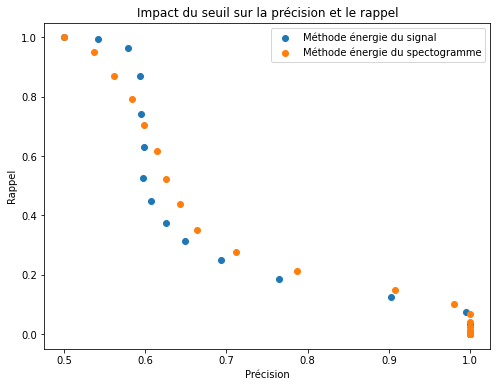

In [71]:
plt.figure(figsize=(8,6))
plt.scatter(Precision_1,Rappel_1,label = 'Méthode énergie du signal')
plt.plt.scatter(Precision_2,Rappel_2,label = 'Méthode énergie du spectogramme')
plt.title('Impact du seuil sur la précision et le rappel')
plt.xlabel('Précision')
plt.ylabel('Rappel')
plt.legend()
plt.show()

Nous pouvons voir que la méthode consistant à calculer l'énergie du spectogramme semble globalement meilleure que celle consistant à calculer directement l'énergie du signal. Comme attendu pour des valeurs de seuil trop élevée, on trouve une précision aux alentours de 1 et un rappel proche de 0 pour les deux méthodes. De même, pour un seuil proche de 0, le rappel est égal à 1 pour les deux méthodes, avec une précision faibles. 

Pour conclure cette étude, nous pouvons dire que si nous voulons détecter la présence d'une impulsion dans un signal à l'aide d'un seuil sur les valeurs d'énergies de celui-ci, il semble préférable d'utiliser l'énergie du spectogramme que celui du signal directement. 